# 0.0 IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
import datetime

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate
from scipy import stats

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contigency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.reParams['figure.figsize'] = [25, 12]
    plt.reParams['font.size'] = 24
    
    display ( HTML( '<style>.container { width:100% !important;}</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

    

## 0.2 Loading Data

In [29]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [30]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
175506,452,2,2015-02-24,3350,360,1,0,0,0,a,c,1850.0,8.0,2013.0,1,5.0,2011.0,"Feb,May,Aug,Nov"


# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [31]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [32]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list ( map( snakecase, cols_old ) )

# rename 
df1.columns = cols_new

## 1.2 Data Dimensions

In [33]:
print( 'Number of row: {}'.format( df1.shape[0] ) )
print( 'Number of row: {}'.format( df1.shape[1] ) )

Number of row: 1017209
Number of row: 18


## 1.3 Data Types

In [34]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [35]:
df1[ 'date' ] = pd.to_datetime( df1[ 'date' ] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [36]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [37]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x ['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x ['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x ['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x ['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )


In [38]:
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [39]:
df1['promo_interval'].fillna( 0, inplace=True )

In [40]:
df1['month_map'] = df1['date'].dt.month.map( month_map )

In [ ]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in df1['promo_interval'].str.split( ',' ) else 0, axis=1 )

In [41]:
df1.sample(5).T

,371207,339702,347181,606007,352551
store,232,564,563,233,282
day_of_week,6,5,4,6,5
date,2014-08-09 00:00:00,2014-09-12 00:00:00,2014-09-04 00:00:00,2014-01-04 00:00:00,2014-08-29 00:00:00
sales,3363,5182,6099,7600,3597
customers,328,485,735,856,587
open,1,1,1,1,1
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,c,d,a,a,a


In [42]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
dtype: int64

## 1.6 Change Types

In [43]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
dtype: object

In [44]:
df1[ 'competition_open_since_month' ] = df1[ 'competition_open_since_month' ].astype( int )
df1[ 'competition_open_since_year' ] = df1[ 'competition_open_since_year' ].astype( int )

df1[ 'promo2_since_week' ] = df1[ 'promo2_since_week' ].astype( int )
df1[ 'promo2_since_year' ] = df1[ 'promo2_since_year' ].astype( int )

## 1.7 Descriptive Statistical

In [45]:
num_attributes = df1.select_dtypes( include = [ 'int64', 'float64' ] )
cat_attributes = df1.select_dtypes( exclude = [ 'int64', 'float64', 'datetime64[ns]' ] )

In [46]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,promo2
978695,511,1,7233,949,1,1,0,2060.0,0
992584,1020,3,10208,1220,1,1,0,40.0,0


### 1.7.1 Numerical Attributes

In [47]:
# Central Tendency = mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

In [48]:
# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index
m.columns( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ] )
m

AttributeError: 'function' object has no attribute 'columns'

C:\Users\User\AppData\Local\Temp\ipykernel_1088\3742112411.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1 ['sales'] )


<AxesSubplot: xlabel='sales', ylabel='Density'>

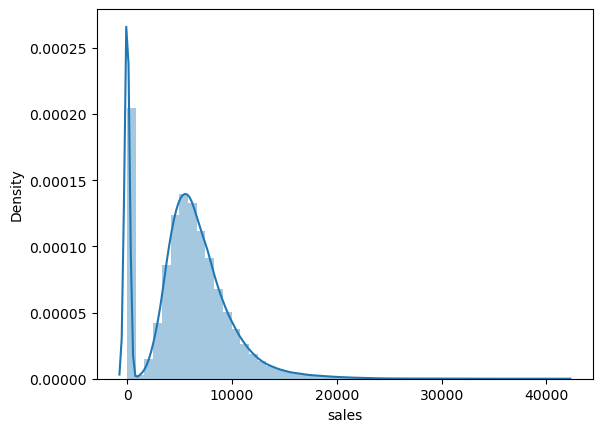

In [49]:
sns.distplot(df1 ['sales'] )

### 1.7.2 Categorical Attributes

In [50]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

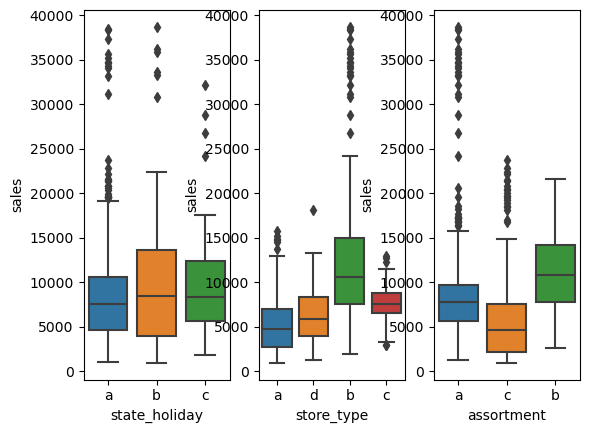

In [51]:
aux1 = df1[ ( df1['state_holiday'] !='0' ) & ( df1['sales'] > 0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [52]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

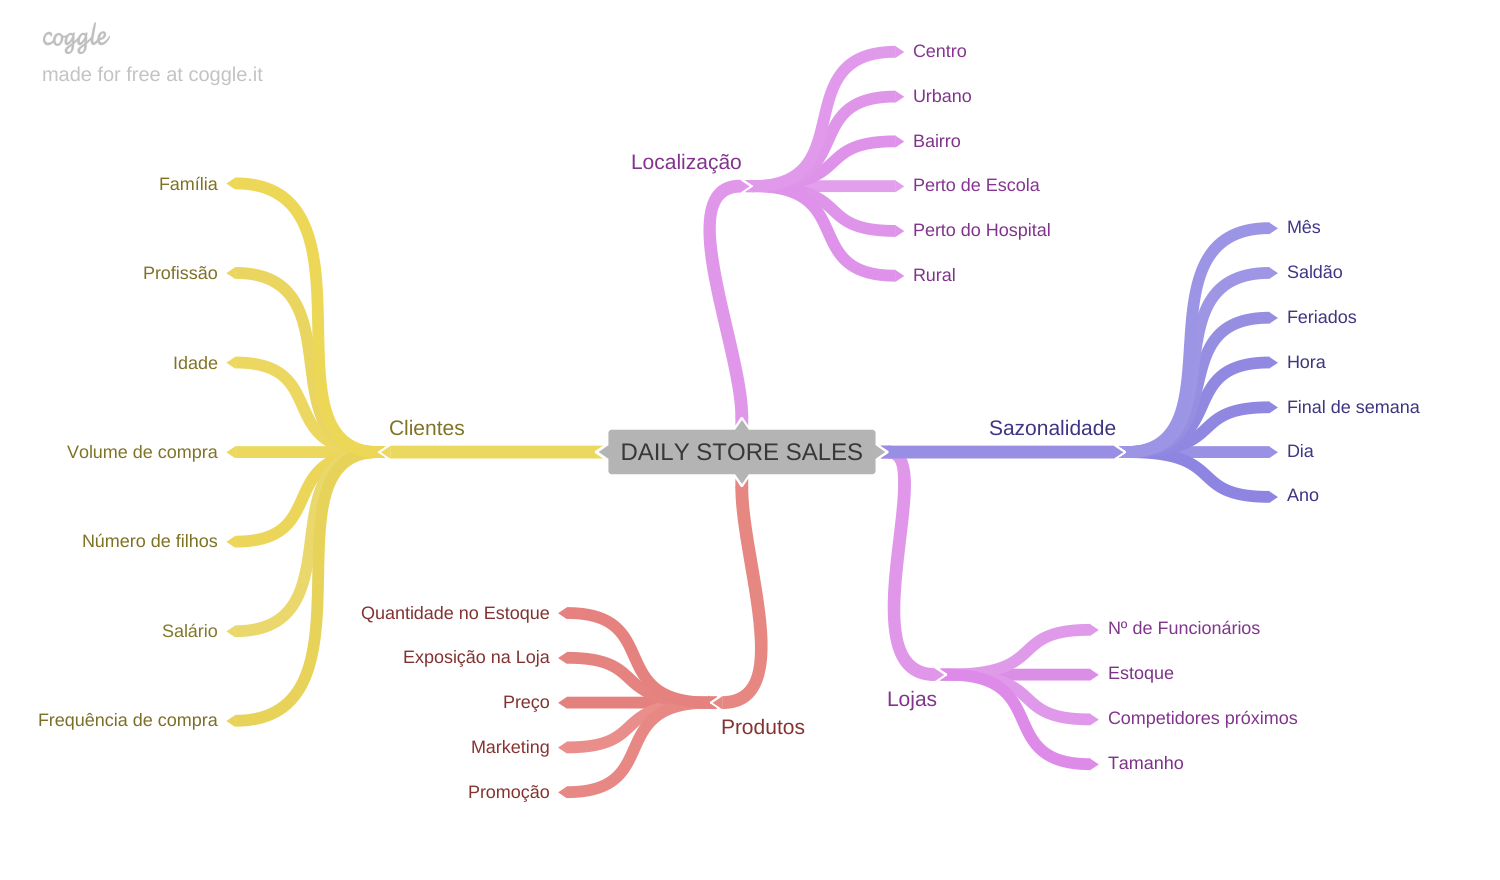

In [53]:
Image( 'img/DAILY_STORE_SALES.png' )

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com competidores mais próximos deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

**6.** Lojas com competidores à mais tempo deveriam vender mais

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas que expoe mais os produtos nas vitrines deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem promoções mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoções deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais



### 2.2.3 Hipóteses Tempo


**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo do ano

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos ao finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares


## 2.3.Lista Final de Hipóteses 

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoções deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais


**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo do ano

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos ao finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.4. Feature Engineering

In [54]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

C:\Users\User\AppData\Local\Temp\ipykernel_1088\2268827306.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [55]:
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

In [56]:
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day' )


In [57]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [58]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [59]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2 Seleção das Colunas

In [60]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [62]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

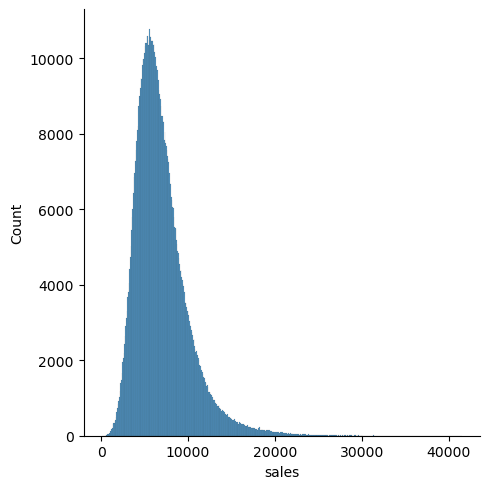

In [63]:
sns.displot( df4['sales'] )

### 4.1.2 Numerical Variable

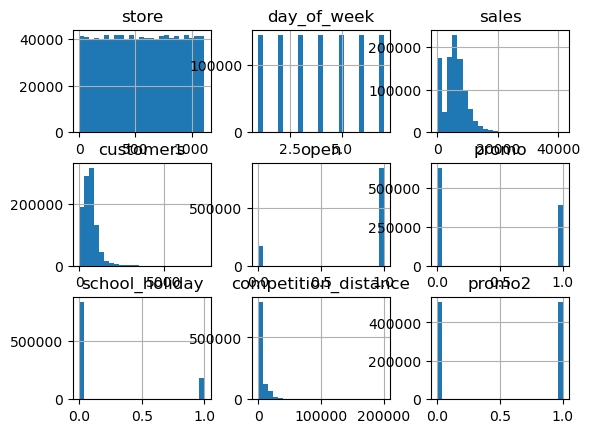

In [64]:
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

In [65]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126        christimas
Name: state_holiday, dtype: object

KeyError: 0

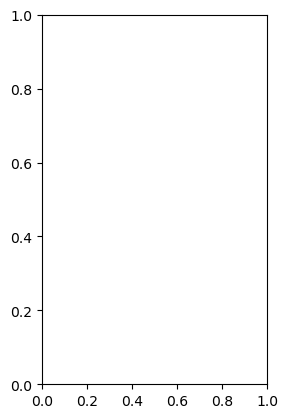

In [67]:
# state_holiday
plt.subplot( 1, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christimas', shade=True)

# store_type
plt.subplot( 2, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
**FALSA** - lojas com MAIOR SORTIMENTO vendem MENOS

<AxesSubplot: xlabel='year_week'>

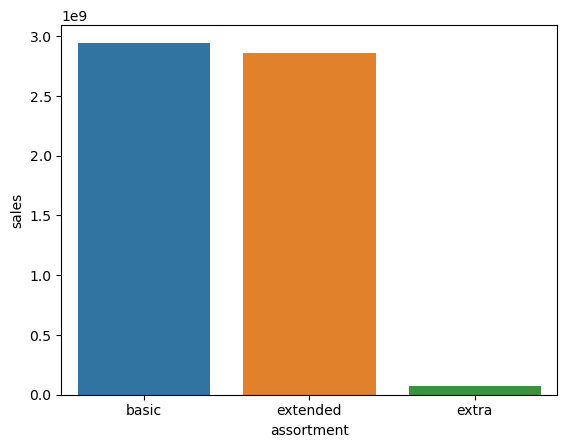

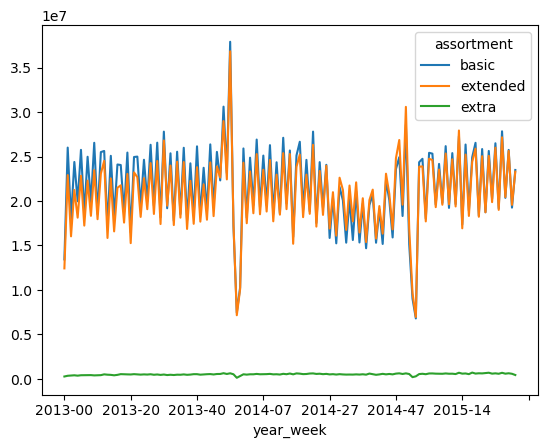

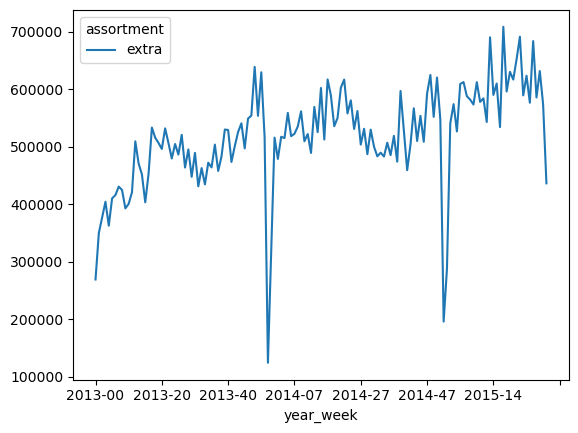

In [68]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos
**FALSA** - Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

C:\Users\User\AppData\Local\Temp\ipykernel_1088\1640755321.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


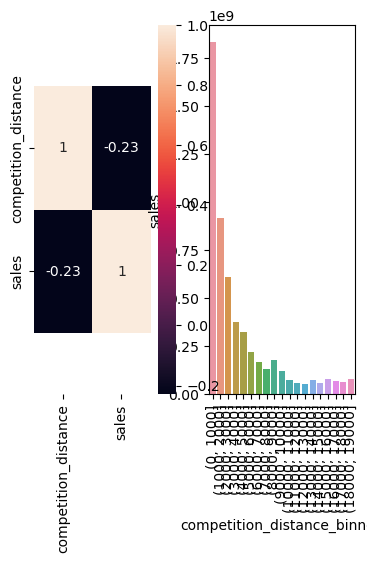

In [69]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 1)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top=x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H3. Lojas com competidores à mais tempo deveriam vender mais
**FALSA** - Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

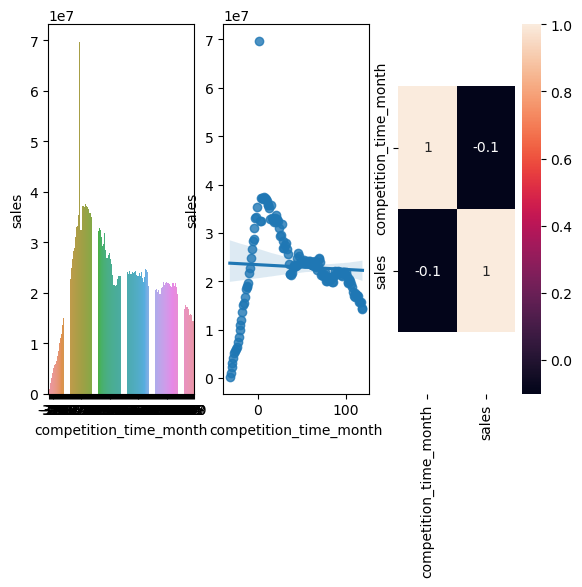

In [70]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top=x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** - Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção

In [71]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] >0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] <0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:, 2] )
sns.heatmap( aux1.corr( method='person'), annot=True );

NameError: name 'GridSpec' is not defined

### <s>H5. Lojas com mais dias de promoções deveriam vender mais</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** - Lojas com mais promoções consecutivas vendem menos

In [72]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


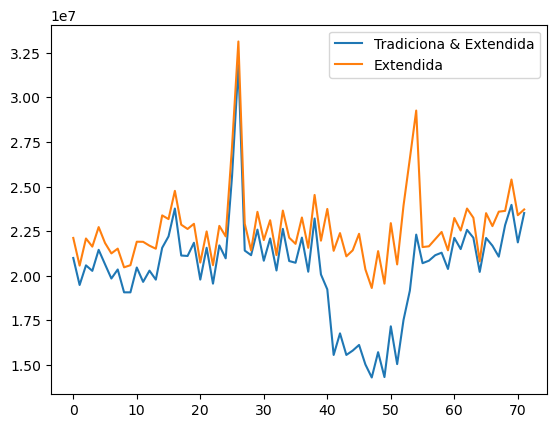

In [73]:
aux1 = df4[( df4['promo'] ==1 ) & ( df4['promo2'] ==1 ) ][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] ==1 ) & ( df4['promo2'] ==0 ) ][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=( 'Tradiciona & Extendida', 'Extendida' ) );

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** - Lojas abertas durante o Natal vendem menos

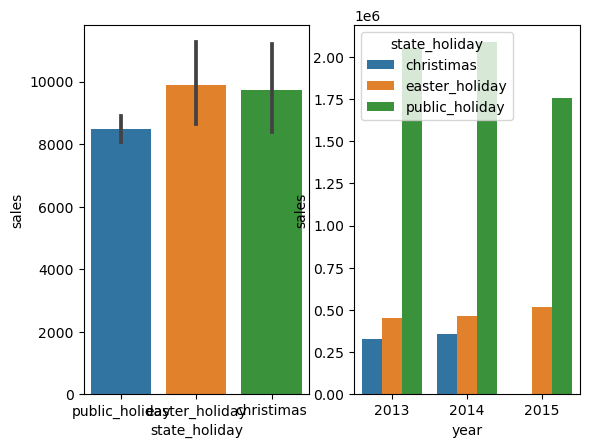

In [74]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( [ 'year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H8. Lojas deveriam vender mais ao longo do ano
**FALSA** - Lojas vendem menos ao longo do ano

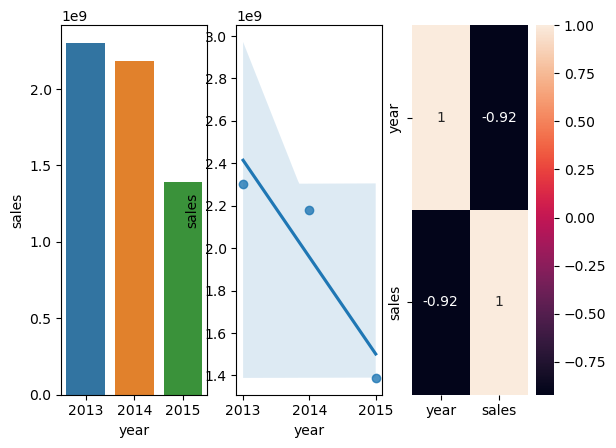

In [75]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year' , y='sales' , data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year' , y='sales' , data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre do ano
**FALSA** - Lojas vendem menos no segundo semestre do ano

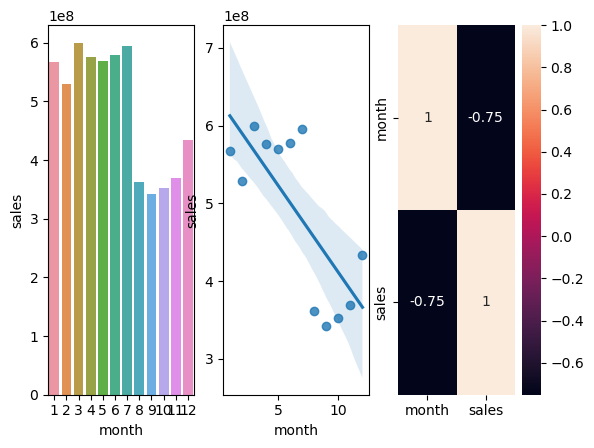

In [76]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month' , y='sales' , data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month' , y='sales' , data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** - As lojas vendem mais depois do dia 10 de cada mês

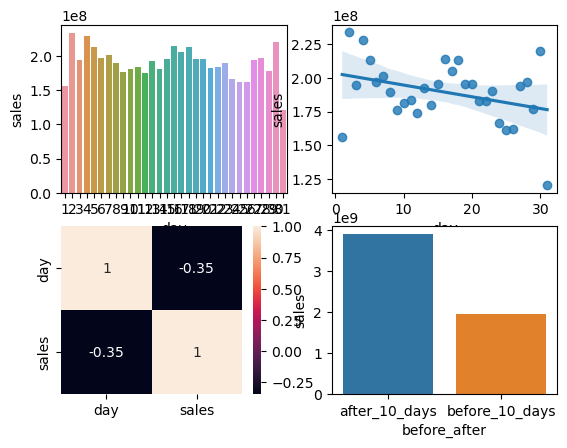

In [77]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day' , y='sales' , data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day' , y='sales' , data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Lojas deveriam vender menos ao finais de semana
**VERDADEIRA** - Lojas vendem menos ao finais de semana

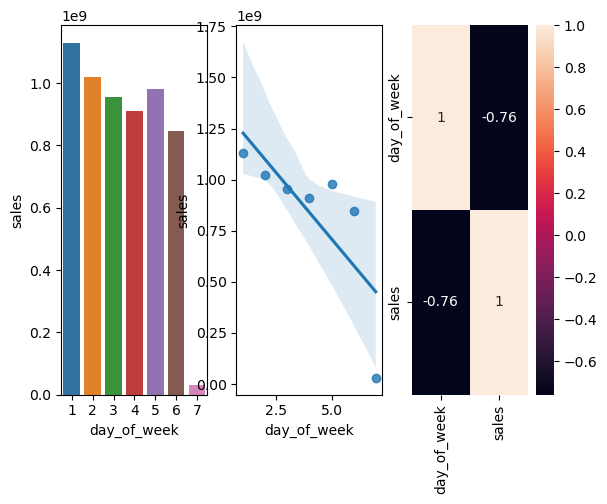

In [78]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week' , y='sales' , data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week' , y='sales' , data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** - Lojas vendem menos durante os feriados escolares, exceto nos meses de Julho e Agosto

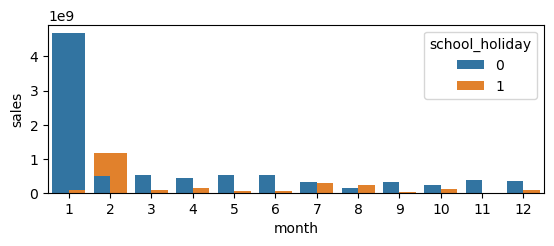

In [81]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1 Resumo das Hipoteses

In [83]:
tab = [['Hipoteses', 'Conclusão', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]
print( tabulate( tab, headers='firstrow' ) )
       

Hipoteses    Conclusão    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

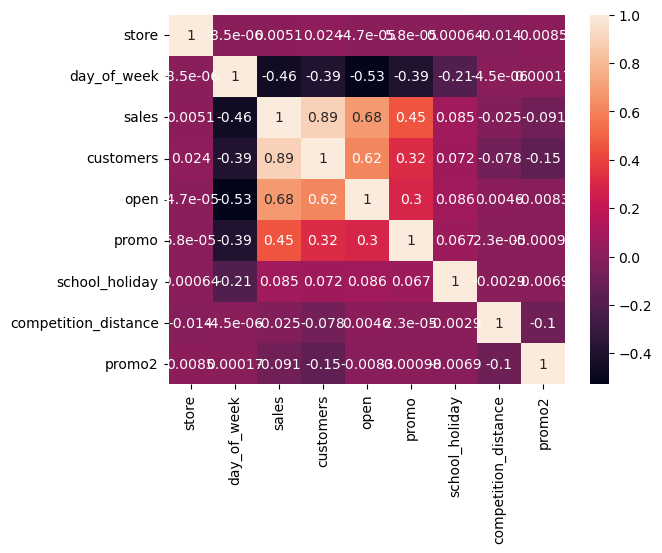

In [85]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

In [ ]:
# Only categorical data
a = df2.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final Dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9] })
                                     
d = d.set_index( d.columns )

In [ ]:
sns.heatmap ( d, annot=True )

# 5.0 PASSO 05 - 

# 6.0 PASSO 06 - 